In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Dropout, MaxPooling2D, AveragePooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
def antisense(r: str):
    l = [{'a':'u','g':'c','c':'g','u':'a'}[x] for x in list(r)[::-1]]
    return ''.join(l)

def encode_c(seq: str, pad: int = 2):
    # dt = {
    #     "a": [[1], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0]],
    #     "g": [[0], [1], [0], [0], [0], [1], [0], [0], [0], [1], [0], [0], [1], [0], [0]],
    #     "c": [[0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [1]],
    #     "u": [[0], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0], [0], [0], [1], [0]],
    # }

    dt = {
        "a": [[1], [0], [0], [0]],
        "g": [[0], [1], [0], [0]],
        "c": [[0], [0], [1], [0]],
        "u": [[0], [0], [0], [1]],
    }

    res = [[[0]] * 4] * pad + [dt[b.lower()] for b in seq] + [[[0]] * 4] * pad
    return res

def decode(mat):
    return ''.join(["AGCU"[l.index([1])] for l in mat[:-2]] + ["agct"[l.index([1])] for l in mat[-2:]])

ter_fe = { "aa": 0.03, "uu": 0.03, "au": 0.38, "ua": 0.16, "cu": 0.55, "ag": -0.19, "ca": 0.08, "ug": -0.05, "gu": 0.55, "ac": -0.05, "ga": 0.39, "uc": -0.20, "cg": -0.10, "gg": -0.16, "cc": 0.0, "gc": -0.12 }
int_fe = { "aa": -0.87, "uu": -0.87, "au": -1.21, "ua": -1.12, "cu": -2.14, "ag": -2.14, "ca": -1.94, "ug": -1.94, "gu": -2.29, "ac": -2.29, "ga": -2.23, "uc": -2.23, "cg": -2.31, "gg": -3.18, "cc": -3.18, "gc": -3.34 }

def encode_b(s: str):
    ther = []

    for i in range(len(s)-1):
        sub = s[i:i+2]
        if i == 0:
            ther.append(ter_fe[sub])
        else:
            ther.append(int_fe[sub])

    overall_stability = sum(ther)
    five_stability = sum(ther[:5])
    three_stabillity = sum(ther[-5:])

    max_hairpin_length = 0
    long_hairpin_count = 0
    for lg in range(1, len(s) // 2 + 1):
        for i in range(len(s) - lg + 1):
            r = s[i:i+lg]
            ar = antisense(r)

            idx = s.find(ar)
            if idx >= i + lg:
                max_hairpin_length = lg
                if lg >= 3:
                    long_hairpin_count += 1

    return [overall_stability, five_stability, three_stabillity] + list(s) + ther

df = pd.read_csv('rna.csv')

encode_c_n = lambda X: np.array(np.frompyfunc(encode_c, 1, 1)(X).tolist()).reshape(-1, 19 + 2 * 2, 4, 1)
encode_b_n = lambda X: np.array(np.frompyfunc(encode_b, 1, 1)(X).tolist()).reshape(-1, 3 + 19 + 18)

X = np.array(df['Sequence'].to_numpy()).reshape(-1, 1)
y = df['Activity'].to_numpy().reshape(-1, 1)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_c = encode_c_n(X)
X_b = encode_b_n(X)

In [10]:
def create_model():
    input_shape = X_c.shape[1:]

    model = keras.Sequential(layers=[
        Conv2D(32, kernel_size=4, activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='mse', optimizer='adam')
    
    return model

Epoch 1/100
54/54 [==============================] - 2s 25ms/step - loss: 0.0214 - val_loss: 0.0169
Epoch 2/100
54/54 [==============================] - 3s 53ms/step - loss: 0.0138 - val_loss: 0.0149
Epoch 3/100
54/54 [==============================] - 8s 144ms/step - loss: 0.0134 - val_loss: 0.0147
Epoch 4/100
54/54 [==============================] - 8s 156ms/step - loss: 0.0118 - val_loss: 0.0150
Epoch 5/100
54/54 [==============================] - 5s 87ms/step - loss: 0.0114 - val_loss: 0.0151
Epoch 6/100
54/54 [==============================] - 5s 86ms/step - loss: 0.0103 - val_loss: 0.0153
0.6040259046674745 0.6213498490118625
Epoch 1/100
54/54 [==============================] - 4s 66ms/step - loss: 0.0194 - val_loss: 0.0164
Epoch 2/100
54/54 [==============================] - 2s 38ms/step - loss: 0.0137 - val_loss: 0.0146
Epoch 3/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0121 - val_loss: 0.0148
Epoch 4/100
54/54 [==============================] - 1s 17ms

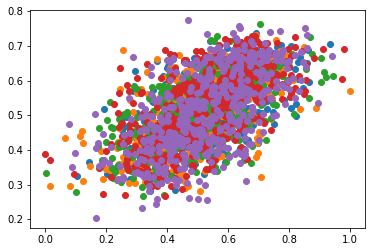

In [26]:
earlystopping = EarlyStopping(min_delta=0.0003, patience=4, restore_best_weights=True)
kf = KFold(5, random_state=42, shuffle=True)

pcc_1 = []
pcc_2 = []

plt.figure()
for train_index, test_index in kf.split(X):
    X_train_c, X_test_c = X_c[train_index], X_c[test_index]
    X_train_b, X_test_b = X_b[train_index], X_b[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    X_train_c, X_val_c, X_train_b, X_val_b, y_train, y_val = train_test_split(X_train_c, X_train_b, y_train, test_size=0.1111111, random_state=42)

    model = create_model()
    history = model.fit(X_train_c, y_train, validation_data=(X_val_c, y_val), epochs=100, callbacks=[earlystopping])
    y_pred_1 = model.predict(X_test_c)

    comp = pd.DataFrame({
        'test': y_test.flatten(),
        'pred': y_pred_1.flatten()
    }).sort_values('test')

    # history_df = pd.DataFrame(history.history)
    # history_df.loc[:, ['loss', 'val_loss']].plot()

    pcc_1.append(np.corrcoef(comp['test'], comp['pred'])[0][1])

    X_train_b_a = np.vstack((np.hstack((X_train_b, model.predict(X_train_c))), np.hstack((X_val_b, model.predict(X_val_c)))))
    y_train_a = np.vstack((y_train, y_val))
    X_test_b_a = np.hstack((X_test_b, model.predict(X_test_c)))
    train_dataset = cb.Pool(X_train_b_a, y_train_a, cat_features=np.arange(3, 3+19))
    test_dataset = cb.Pool(X_test_b_a, y_test, cat_features=np.arange(3, 3+19))

    cbmodel = cb.CatBoostRegressor(loss_function="RMSE", learning_rate=0.1, max_leaves=31, logging_level='Silent')

    grid = {'iterations': [100, 200, 300],
            'depth': [4, 6, 8],
            'l2_leaf_reg': [0.2, 0.5, 1, 3]}
    
    cbmodel.grid_search(grid, train_dataset, verbose=False)

    y_pred_2 = cbmodel.predict(X_test_b_a)
    pcc_2.append(np.corrcoef(y_test.ravel(), y_pred_2)[0][1])

    plt.scatter(y_test.ravel(), y_pred_2)
    
    print(pcc_1[-1], pcc_2[-1])

print(pcc_1, pcc_2)
plt.show()

10it [06:48, 40.84s/it]

[0.6618242776688671, 0.5918021382694307, 0.5588480429140011, 0.6600322699071293, 0.6191425897735432, 0.650716850173148, 0.6168906368913077, 0.6449873518701947, 0.6020484946219747, 0.620789822286141]


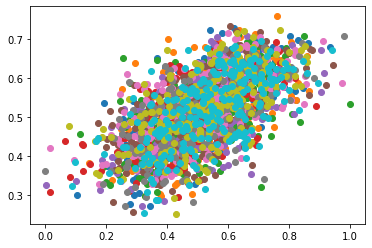

In [29]:
kf = KFold(10, random_state=42, shuffle=True)

pcc_b = []

plt.figure()
for train_index, test_index in tqdm(kf.split(X)):
    X_train_b, X_test_b = X_b[train_index], X_b[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    
    train_dataset = cb.Pool(X_train_b, y_train, cat_features=np.arange(3, 3+19))

    cbmodel = cb.CatBoostRegressor(loss_function="RMSE", learning_rate=0.1, max_leaves=31, logging_level='Silent')

    grid = {'iterations': [100, 200, 300],
            'depth': [4, 6, 8],
            'l2_leaf_reg': [0.2, 0.5, 1, 3]}
    
    cbmodel.grid_search(grid, train_dataset, verbose=False)

    y_pred = cbmodel.predict(X_test_b)
    pcc_b.append(np.corrcoef(y_test.ravel(), y_pred)[0][1])

    plt.scatter(y_test.ravel(), y_pred)
    
print(pcc_b)
plt.show()

In [30]:
sum(pcc_b)

6.227082474375736

In [652]:
y_pred = cbmodel.predict(X_test_t)
print(f"PCC: {np.corrcoef(y_test.ravel(), y_pred)[0][1]}")
print(f"MSE: {mean_squared_error(y_test.ravel(), y_pred)}")

PCC: 0.6605393058409436
MSE: 0.012436339640966599


In [651]:
cbmodel.feature_importances_

array([ 3.4199459 ,  2.33024271,  1.83350614,  1.70544662,  1.15557746,
        0.86570581,  0.74059584, 87.94897952])

In [23]:
cbmodel = cb.CatBoostRegressor(loss_function="RMSE", learning_rate=0.1, max_leaves=31)
X_train_b, X_test_b, y_train, y_test = train_test_split(X_b, y, test_size=0.1, random_state=42)

grid = {'iterations': [100, 200, 300],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

train_dataset = cb.Pool(X_train_b, y_train, cat_features=np.arange(3, 3+19))
params = cbmodel.grid_search(grid, train_dataset, verbose=False)

y_pred = cbmodel.predict(X_test_b)
np.corrcoef(y_pred, y_test.flatten())

0:	learn: 0.4886726	test: 0.4851354	best: 0.4851354 (0)	total: 1.76ms	remaining: 174ms
1:	learn: 0.4446251	test: 0.4410758	best: 0.4410758 (1)	total: 3.62ms	remaining: 178ms
2:	learn: 0.4053302	test: 0.4018340	best: 0.4018340 (2)	total: 5.17ms	remaining: 167ms
3:	learn: 0.3704119	test: 0.3669707	best: 0.3669707 (3)	total: 6.92ms	remaining: 166ms
4:	learn: 0.3392461	test: 0.3359521	best: 0.3359521 (4)	total: 8.58ms	remaining: 163ms
5:	learn: 0.3118338	test: 0.3087949	best: 0.3087949 (5)	total: 10.3ms	remaining: 161ms
6:	learn: 0.2875825	test: 0.2850305	best: 0.2850305 (6)	total: 11.5ms	remaining: 153ms
7:	learn: 0.2658919	test: 0.2633801	best: 0.2633801 (7)	total: 12.9ms	remaining: 148ms
8:	learn: 0.2474846	test: 0.2450425	best: 0.2450425 (8)	total: 14.5ms	remaining: 147ms
9:	learn: 0.2313590	test: 0.2290877	best: 0.2290877 (9)	total: 16ms	remaining: 144ms
10:	learn: 0.2173375	test: 0.2152184	best: 0.2152184 (10)	total: 17.6ms	remaining: 142ms
11:	learn: 0.2053774	test: 0.2034376	best: 

array([[1.        , 0.66668297],
       [0.66668297, 1.        ]])

In [24]:
params, cbmodel.feature_importances_

({'params': {'max_leaves': 31,
   'depth': 6,
   'iterations': 200,
   'l2_leaf_reg': 0.2},
  'cv_results': defaultdict(list,
              {'iterations': [0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                16,
                17,
                18,
                19,
                20,
                21,
                22,
                23,
                24,
                25,
                26,
                27,
                28,
                29,
                30,
                31,
                32,
                33,
                34,
                35,
                36,
                37,
                38,
                39,
                40,
                41,
                42,
          

In [284]:
params = {'boosting_type': 'gbdt', 'num_leaves': 7, 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 50, 'subsample_for_bin': 300, 'objective': 'regression', 'class_weight': None, 'random_state': 42, 'metric': 'mse'}

lgbmodel = lgb.LGBMRegressor()
lgbmodel.set_params(**params)
lgbmodel.fit(X_train_t, y_train_t)

/home/hamerin/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(max_depth=3, metric='mse', n_estimators=50, num_leaves=7,
              objective='regression', random_state=42, subsample_for_bin=300)

In [340]:
y_pred = lgbmodel.predict(X_test_t)
print(f"PCC: {np.corrcoef(y_test.ravel(), y_pred)[0][1]}")
print(f"MSE: {mean_squared_error(y_test.ravel(), y_pred)}")

PCC: 0.6476926923358762
MSE: 0.013201899170548127


In [341]:
lgbmodel.feature_importances_

array([ 62,  31,  33,  22, 127], dtype=int32)

In [342]:
X_train_t

array([[ 0.6693893 , -0.21548818, -0.09287442, -1.11014427,  0.61136115],
       [ 0.0192066 , -0.3357336 ,  0.00841878,  0.02617603,  0.5417366 ],
       [ 0.40846072, -0.83762751,  0.02771272,  1.16249633,  0.50985926],
       ...,
       [ 0.53892501,  1.4470354 ,  1.06476208,  0.02617603,  0.59177065],
       [-0.64594741, -0.59190862, -1.60744883, -1.11014427,  0.58280265],
       [ 1.27251931,  1.83391196,  0.57276657,  0.02617603,  0.49706647]])

In [565]:
model.save("cnn_2432_0.6591")

INFO:tensorflow:Assets written to: cnn_2432_0.6591/assets


In [690]:
reconstructed_model = keras.models.load_model("cnn_2432_0.6572")


In [692]:
reconstructed_model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 29, 1, 32)         1440      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 29, 1, 64)         32832     
_________________________________________________________________
flatten_40 (Flatten)         (None, 1856)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 128)               237696    
_________________________________________________________________
dense_121 (Dense)            (None, 16)                2064      
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 17        
Total params: 274,049
Trainable params: 274,049
Non-trainable params: 0
_______________________________________________